In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
init = pd.read_csv('locationData/time_wav5.csv', header=None).T
u7 = pd.read_csv('locationData/unit7.csv')
u8 = pd.read_csv('locationData/unit8.csv')
u13 = pd.read_csv('locationData/unit13.csv')
u20 = pd.read_csv('locationData/unit20.csv')

startTime = init.iloc[1][0]
endTime = init.iloc[1][1]
print(startTime, endTime)

236880 238080


In [4]:
u7['GPS_time']=u7['GPS_time']-startTime
u8['GPS_time']=u8['GPS_time']-startTime
u13['GPS_time']=u13['GPS_time']-startTime
u20['GPS_time']=u20['GPS_time']-startTime


In [5]:
sampFreq = 65501
u7snaps = pd.read_csv('PeakTimeLocationData/Unit7PeakTimes.csv', header=None, names = ["dirtime", "reftime"])
u8snaps = pd.read_csv('PeakTimeLocationData/Unit8PeakTimes.csv', header=None, names = ["dirtime", "reftime"])
u13snaps = pd.read_csv('PeakTimeLocationData/Unit13PeakTimes.csv', header=None, names = ["dirtime", "reftime"])
u20snaps = pd.read_csv('PeakTimeLocationData/Unit20PeakTimes.csv', header=None, names = ["dirtime", "reftime"])



In [6]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
time = u7['GPS_time']
xpos = u7['x']
ypos = u7['y']

In [7]:
tnew = np.linspace(0, 1200, num=1201)
xinter = interp1d(time, xpos, kind='nearest')
yinter = interp1d(time, ypos, kind='nearest')

### u7pos is an interpolation from 0 to 1000 
### u7test

In [8]:
u7 = u7[u7['GPS_time'] <= 1100]  
u8 = u8[u8['GPS_time'] <= 1100]  
u13 = u13[u13['GPS_time'] <= 1100]  
u20 = u20[u20['GPS_time'] <= 1100]  


In [9]:
tnew = np.linspace(20, 1000, num=981)
u7pos = pd.DataFrame({'time':tnew, 'xpos':interp1d(u7['GPS_time'], u7['x'], kind='nearest')(tnew),
                      'ypos':interp1d(u7['GPS_time'], u7['y'], kind='nearest')(tnew)})

u8pos = pd.DataFrame({'time':tnew, 'xpos':interp1d(u8['GPS_time'], u8['x'], kind='nearest')(tnew),
                      'ypos':interp1d(u8['GPS_time'], u8['y'], kind='nearest')(tnew)})

u13pos = pd.DataFrame({'time':tnew, 'xpos':interp1d(u13['GPS_time'], u13['x'], kind='nearest')(tnew),
                      'ypos':interp1d(u13['GPS_time'], u13['y'], kind='nearest')(tnew)})

u20pos = pd.DataFrame({'time':tnew, 'xpos':interp1d(u20['GPS_time'], u20['x'], kind='nearest')(tnew),
                      'ypos':interp1d(u20['GPS_time'], u20['y'], kind='nearest')(tnew)})

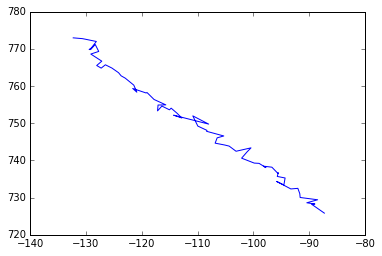

In [10]:
plt.plot(u7pos['xpos'], u7pos['ypos'])
plt.show();

In [11]:
u7snaps['dirtimer'] = u7snaps['dirtime'].round()
u7snaps = u7snaps.loc[:, ['dirtime', 'dirtimer']];

u7snaps=u7snaps[u7snaps['dirtime'] >= 0]
u8snaps=u8snaps[u8snaps['dirtime'] >= 0]
u13snaps=u13snaps[u13snaps['dirtime'] >= 0]
u20naps=u20snaps[u20snaps['dirtime'] >= 0]

p = u7snaps[u7snaps['dirtimer'] < 1000]['dirtimer']



In [12]:
u7snaps['dirtimer'] = u7snaps['dirtime'].round()
u7snaps = u7snaps.loc[:, ['dirtime', 'dirtimer']];
u7postime = u7pos.loc[u7pos['time'].isin(p)]
u7postime = u7postime.drop_duplicates()

u8snaps['dirtimer'] = u8snaps['dirtime'].round()
u8snaps = u8snaps.loc[:, ['dirtime', 'dirtimer']];
u8postime = u8pos.loc[u8pos['time'].isin(p)]
u8postime = u8postime.drop_duplicates()

u13snaps['dirtimer'] = u13snaps['dirtime'].round()
u13snaps = u13snaps.loc[:, ['dirtime', 'dirtimer']];
u13postime = u13pos.loc[u13pos['time'].isin(p)]
u13postime = u13postime.drop_duplicates()

u20snaps['dirtimer'] = u20snaps['dirtime'].round()
u20snaps = u20snaps.loc[:, ['dirtime', 'dirtimer']];
u20postime = u20pos.loc[u20pos['time'].isin(p)]
u20postime = u20postime.drop_duplicates()

In [13]:
direct = pd.DataFrame()

direct['u7dir'] = u7snaps[u7snaps['dirtimer'] < 1000]['dirtime']
direct['u8dir'] = u8snaps[u8snaps['dirtimer'] < 1000]['dirtime']
direct['u13dir'] = u13snaps[u13snaps['dirtimer'] < 1000]['dirtime']
direct['u20dir'] = u20snaps[u20snaps['dirtimer'] < 1000]['dirtime']

dirdiff = pd.DataFrame()
dirdiff['7-8'] = direct['u7dir']-direct['u8dir']
dirdiff['7-13'] = direct['u7dir']-direct['u13dir']
dirdiff['7-20'] = direct['u7dir']-direct['u20dir']
dirdiff['8-13'] = direct['u8dir']-direct['u13dir']
dirdiff['8-20'] = direct['u8dir']-direct['u20dir']
dirdiff['13-20'] = direct['u13dir']-direct['u20dir']

dirdiff.insert(0, "time", u7snaps['dirtimer'])


In [14]:
def getPosAtTime(t):
    u7p = u7postime.loc[u7postime['time']==t][['xpos','ypos']]
    u8p = u8postime.loc[u8postime['time']==t][['xpos','ypos']]
    u13p = u13postime.loc[u13postime['time']==t][['xpos','ypos']]
    u20p = u20postime.loc[u20postime['time']==t][['xpos','ypos']]
    return [u7p, u8p, u13p, u20p]

#getTimeDiff at signal specified at second s
def getTimeDiffAtTime(t):
    return dirdiff.loc[dirdiff['time']==t].values[0][1:7]


In [15]:

getPosAtTime(26)

[        xpos        ypos
 6 -87.283773  725.824537,         xpos        ypos
 6 -93.342424  684.416364,        xpos        ypos
 6 -9.990024  673.012236,         xpos        ypos
 6 -40.470198  720.841834]

In [16]:
getPosAtTime(89)

[         xpos        ypos
 69 -91.687425  731.059533,          xpos        ypos
 69 -96.753014  687.882339,          xpos        ypos
 69 -12.148667  675.183271,          xpos        ypos
 69 -43.986596  722.824241]

In [17]:
def getDiffFromShrimp(shrimpPos):
    diff = [[0,0],[0,0],[0,0],[0,0]]
    for i in range(len(auvPos)):
        #print(shrimpPos[0])
        #print(auvPos[i][0])
        #print(shrimpPos[0])
        diff[i] = [float(shrimpPos[0] - auvPos[i]['xpos']), float(shrimpPos[1] - auvPos[i]['ypos'])];
    return diff


def loss(s):
    error = np.zeros(6)
    k = 0
    diff = getDiffFromShrimp(s)
    for i in range(4):
        for j in range(i+1,4):
            #print(i,j)
            #print(s)
            error[k] = timediff[k]-(np.linalg.norm(diff[i])-np.linalg.norm(diff[j]))
            
            k = k+1
    return error


In [18]:
auvPos = getPosAtTime(26)
auvPos[0]

a = getDiffFromShrimp([-100, 100])
a[0]

[-12.716227070000002, -625.824537]

In [19]:
auvPos[0]

,xpos,ypos
6,-87.283773,725.824537


In [20]:
getTimeDiffAtTime(26)

array([-0.01935848, -0.06207539, -0.02683928, -0.04271691, -0.0074808 ,
        0.0352361 ])

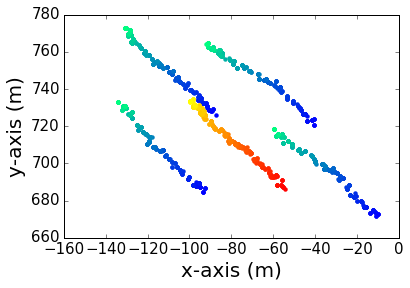

In [61]:
from scipy.optimize import least_squares
from matplotlib import cm
co=0
colors=['red','green','blue', 'orange', 'purple']
t = np.arange(100)
colors = cm.winter(np.linspace(0,1,266))
colors2 = cm.autumn(np.linspace(0,1,266))

for i in dirdiff['time']:
    #print(auvPos)
    auvPos = getPosAtTime(i)
    timediff = getTimeDiffAtTime(i)
    try:
        initial_estimates=[-200,-80]
        res = least_squares(loss, initial_estimates)
        #print(i)
        plt.scatter(res.x[0],res.x[1],c=colors2[co], cmap=cm.hot, linewidth=0.0)
    except TypeError:
        continue
    #plt.scatter(auvPos[:,0],auvPos[:,1],c='b')
    #plt.scatter(res.x[0],res.x[1],c=co)
    plt.scatter(auvPos[0]['xpos'],auvPos[0]['ypos'],c=colors[co], cmap=cm.jet, linewidth=0.0)
    plt.scatter(auvPos[1]['xpos'],auvPos[1]['ypos'],c=colors[co], cmap=cm.jet, linewidth=0.0)
    plt.scatter(auvPos[2]['xpos'],auvPos[2]['ypos'],c=colors[co], cmap=cm.jet, linewidth=0.0)
    plt.scatter(auvPos[3]['xpos'],auvPos[3]['ypos'],c=colors[co], cmap=cm.jet, linewidth=0.0)
    co = (co + 1) % 266

#    plt.xlim(-5000,100)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('axes', labelsize=20) 
plt.xlabel('x-axis (m)')
plt.ylabel('y-axis (m)')
plt.show()

    

In [53]:
len(dirdiff['time'])

266

In [40]:
print(cm.jet)[0]


TypeError: 'NoneType' object is not subscriptable

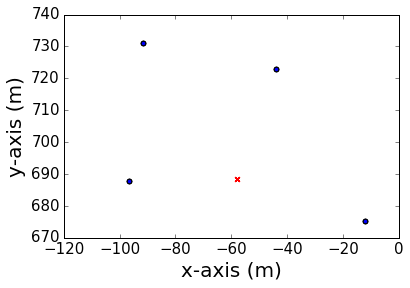

[ -58.03148161  688.51560665]
[         xpos        ypos
69 -91.687425  731.059533,          xpos        ypos
69 -96.753014  687.882339,          xpos        ypos
69 -12.148667  675.183271,          xpos        ypos
69 -43.986596  722.824241]


In [22]:
i = 89
auvPos = getPosAtTime(i)
#print(auvPos)
timediff = getTimeDiffAtTime(i)

initial_estimates=[-1000,-1000]
for i in range(-1000, 0, 250):
    for j in range(-1000, 0, 250):
        init =  [i,j];
        res = least_squares(loss, init)
        plt.scatter(res.x[0],res.x[1],marker='x',c='r')
    plt.scatter(auvPos[0]['xpos'],auvPos[0]['ypos'],c='b')
    plt.scatter(auvPos[1]['xpos'],auvPos[1]['ypos'],c='b')
    plt.scatter(auvPos[2]['xpos'],auvPos[2]['ypos'],c='b')
    plt.scatter(auvPos[3]['xpos'],auvPos[3]['ypos'],c='b')

plt.xlabel('x-axis (m)')
plt.ylabel('y-axis (m)')
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('axes', labelsize=20) 
plt.show();
print(res.x)
print(auvPos)

In [23]:
timediff = getTimeDiffAtTime(89)


In [24]:
timediff

array([ 0.02529732, -0.01661043, -0.01995389, -0.04190776, -0.04525122,
       -0.00334346])